In [1034]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pylab as plt
from matplotlib import cm
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Functions

In [957]:
def aggregate_course(df):
    '''
    This function cleans up the data for a given accreditation criteria.
    Valuing completed coures as 1 and booked courses and 0.5. 
    Each course is weighted by the total number for that criteria and summed to give a fraction.
    The DataFrame is then update.
    '''
    #replace categoricals with numeric values
    df.replace('Complete',1.0,inplace=True)
    df.replace('Booked',0.5,inplace=True)
    df.fillna(0,inplace=True)
    #Drop the 'unreleased column'
    df.drop(df.columns[-1:],axis=1,inplace=True)

    #wieghting
    total_course_fraction = []
    total_course_completion = []
    l = len(df)
    
    for i in range(l):
        course_completion = df.iloc[[i]].values[0][5:]
        course_fraction = sum(map(lambda x: x/len(course_completion), course_completion))
        total_course_fraction.append(course_fraction)
        if course_fraction > 0.999:
            total_course_completion.append(1)
        else:
            total_course_completion.append(0)

    #Update Dataframe
    df['Total fraction'] = pd.Series(total_course_fraction, index=df.index)
    df['Total completion'] = pd.Series(total_course_completion, index=df.index)
    
    return df


In [919]:
def course_completion(dealers,criteria):
    '''
    Count people who completed the criteria and calculation a dealership completion fraction
    
    Calculate:
    a) the number of people on the course, 
    b) number of completions on the course,
    c) fraction of people who have completed across a dealer.
    '''

    total_completion_dict = {}
    total_completion_results = []

    for i in dealers:
        people_total = 0
        completed_total = 0
        for j in criteria:
            try:
                dg = j.groupby('Code').get_group(i)
                people = len(dg['Total completion'])
                completed = len(dg.loc[dg['Total completion'] == 1.0])
                completion_frac = round(float(completed)/float(people),2)
            except:
                people = 0
                completed = 0
                completion_frac = np.nan
            
            total_completion_results.append(completion_frac)
            people_total = people_total + people
            completed_total = completed_total + completed
        
        total_completion_results.append(round(np.nansum(float(completed_total))/np.nansum(float(people_total)),2))
        total_completion_dict[i] = total_completion_results
        total_completion_results = []

    #Produce DataFrame with results    
    df_completion = pd.DataFrame(data=total_completion_dict)
    df_completion = df_completion.T
    df_completion.columns=['MT','SC','SA','T','All']
    return df_completion

In [1126]:
def course_progress(dealers,criteria):
    '''
    Find the mean course completion fraction, per criteria, per dealership
    
    Calculates:
    a) the mean completion fraction for staff of a given criteria, per dealership
    b) the mean completion of all staff in a dealership
    '''
    mean_list = []
    std_list = []
    sum_list = []
    mean_dict = {}
    std_dict = {}
    grand_mean_list = []

    for i in dealers:
        #print i
        for j in criteria:
            try:
                dg = j.groupby('Code').get_group(i)
                #print dg['Total fraction'].values, np.mean(dg['Total fraction'].values)
                mean = round(np.mean(dg['Total fraction'].values),4)
                std = round(np.std(dg['Total fraction'].values/np.sqrt(len(dg['Total fraction'].values))),4)
                sums = np.nansum(dg['Total fraction'].values)
                mean_list.append(mean)
                std_list.append(std)
                grand_mean_list.append(dg['Total fraction'].values)
            except:
                mean_list.append(np.nan)
                std_list.append(np.nan)
        
        #print mean_list
        dealer_mean = np.nanmean(np.concatenate(grand_mean_list))
        dealer_std = np.nanstd(np.concatenate(grand_mean_list))/np.sqrt(len(np.concatenate(grand_mean_list)))
        mean_list.append(round(dealer_mean,4))
        std_list.append(round(dealer_std,4))
        sum_list.append(sums)
        mean_dict[i] = mean_list
        std_dict[i] = std_list
        mean_list = []
        std_list = []
        grand_mean_list = []

    df_progress = pd.DataFrame(data=mean_dict)
    df_progress = df_progress.T
    df_progress.columns=['MT','SC','SA','T','ALL']
    
    df_progress_std = pd.DataFrame(data=std_dict)
    df_progress_std = df_progress_std.T
    df_progress_std.columns=['MT','SC','SA','T','ALL']
    return df_progress, df_progress_std


df_progress, df_progress_std = course_progress(dealers,criteria)#
print df_progress.ix[1651]
print df_progress_std.ix[1651]

MT     0.7500
SC     0.9977
SA     0.7151
T      0.4964
ALL    0.7423
Name: 1651, dtype: float64
MT     0.0707
SC     0.0021
SA     0.1866
T      0.0940
ALL    0.0676
Name: 1651, dtype: float64


In [1107]:
df_SC.groupby('Code').get_group(1651)

,Username,First Name,Last Name,Code,Dealership,N-GAGE Sales Consultant TNA,Nissan Sales 1,Nissan Sales 2,Added Value Sales,VCT: The Nissan Brand,...,NSSW e-Learning,Sales NSSW: Customer Quality in Action,Nissan Accessories and Personalisation,Nissan Warranty for Sales,Quality: Approaching the Customer,Quality: Handover,Quality: Mindfulness at Work,All New Micra Part 1,Total fraction,Total completion
37,231042,Zac,Berlyn,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
47,231594,Martyn,Taylor,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.983871,0
52,231925,Jonathan,Goddard,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
58,231924,Matthew,Green,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
66,228391,Derek,Fardy,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
71,230570,Matthew,Smith,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1
74,226348,Ian,Woodier,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1


# Load data

In [946]:
#Load staff data
file_name = 'West_Way_Accreditation/20161207 FY16 West Way Accreditation Report.xlsx'

xl_file = pd.ExcelFile(file_name)
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

#Save DF for each course
df_SC = dfs['SC Report']
df_T = dfs['T Report']
df_SA = dfs['SA Report']
df_MT = dfs['MT Report']

In [947]:
#Load target data
targets = 'West_Way_Accreditation/FY16 West Way Dealer Accreditation Targets.xlsx'

xl_file = pd.ExcelFile(targets)
dfs = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

#Save DF for each course
df_targets = dfs['FY16 Targets']
df_targets.fillna(0,inplace=True)

# Clean/crop data

In [948]:
#Adjusting the headers 
df_SC.columns = df_SC.iloc[[4]].values[0]
df_SC.drop(df_SC.index[0:5],inplace=True)

#Adjusting the headers 
df_T.columns = df_T.iloc[[4]].values[0]
df_T.drop(df_T.index[0:5],inplace=True)

#Adjusting the headers 
df_SA.columns = df_SA.iloc[[4]].values[0]
df_SA.drop(df_SA.index[0:5],inplace=True)

#Adjusting the headers 
df_MT.columns = df_MT.iloc[[4]].values[0]
df_MT.drop(df_MT.index[0:5],inplace=True)

In [949]:
#Drop common surplus headers
surplus_headers_SC = df_SC.columns[5:13]
surplus_headers_T = df_T.columns[5:11]
surplus_headers_SA = df_SA.columns[5:12]
surplus_headers_MT = df_MT.columns[5:12]

df_SC.drop(surplus_headers_SC,1,inplace=True)
df_T.drop(surplus_headers_T,1,inplace=True)
df_SA.drop(surplus_headers_SA,1,inplace=True)
df_MT.drop(surplus_headers_MT,1,inplace=True)

In [950]:
#Reduce to F2F only
df_SC_F2F = df_SC.drop(df_SC.columns[12:25],1).drop(df_SC.drop(df_SC.columns[12:25],1).columns[15:],1)
df_T_F2F = df_T.drop(df_T.columns[6:],1)
df_SA_F2F = df_SA.drop(df_SA.columns[10:24],1).drop(df_SA.drop(df_SA.columns[10:24],1).columns[11:],1)
df_MT_F2F = df_MT.drop(df_MT.columns[8:16],1).drop(df_MT.drop(df_MT.columns[8:16],1).columns[9:],1)

In [951]:
#Reduce to Initial only
df_SC_init = df_SC[df_SC.columns[0:25]]
df_T_init = df_T[df_T.columns[0:13]]
df_SA_init = df_SA[df_SA.columns[0:24]]
df_MT_init = df_MT[df_MT.columns[0:16]]

In [952]:
df_SC.columns[-1:]

Index([u'FY16 Sales Consultant Knowledge Retention Assessment (coming soon)'], dtype='object')

# Analysis

In [1061]:
#df_SA.groupby('Code').get_group(1877)

In [958]:
#Full DataSet
df_SC = aggregate_course(df_SC)
df_T = aggregate_course(df_T)
df_SA = aggregate_course(df_SA)
df_MT = aggregate_course(df_MT)

#F2F
df_SC_F2F = aggregate_course(df_SC_F2F)
df_T_F2F = aggregate_course(df_T_F2F)
df_SA_F2F = aggregate_course(df_SA_F2F)
df_MT_F2F = aggregate_course(df_MT_F2F)

#Initail DataSet
df_SC_init = aggregate_course(df_SC_init)
df_T_init = aggregate_course(df_T_init)
df_SA_init = aggregate_course(df_SA_init)
df_MT_init = aggregate_course(df_MT_init)

In [1059]:
#deffine dealers    
dealership_names = {1525:'Basingstoke',1533:'Southampton',1535:'Aldershot',
                    1633:'Coventry',1650:'Birmingham',1651:'Stourbridge',
                    1655:'Wolverhampton',1692:'Stockport',1693:'Rochdale',
                    1694:'Oldham',1708:'Manchester',1877:'Hanwell',
                    1878:'Mill Hill',1883:'Altrincham'}

dealers = sorted(dealership_names.iterkeys())

In [1111]:
#Deffine the criteria - 12 MONTHS
criteria = [df_MT,df_SC,df_SA,df_T]
df_completion = course_completion(dealers,criteria)
df_progress, df_progress_std = course_progress(dealers,criteria)

#Deffine the criteria - F2F
criteria_6 = [df_MT_6,df_SC_6,df_SA_6,df_T_6]
df_completion_6 = course_completion(dealers,criteria_6)
df_progress_6 = course_progress(dealers,criteria_6)

#Deffine the criteria - Initial criteria
criteria_init = [df_MT_init,df_SC_init,df_SA_init,df_T_init]
df_completion_init = course_completion(dealers,criteria_init)
df_progress_init, df_progress_init_std = course_progress(dealers,criteria_init)

In [1112]:
df_completion.ix[1651]

MT     0.00
SC     0.86
SA     0.00
T      0.00
All    0.32
Name: 1651, dtype: float64

In [1113]:
df_progress.ix[1651]

MT     0.7500
SC     0.9977
SA     0.7151
T      0.4964
ALL    0.7423
Name: 1651, dtype: float64

In [1114]:
df_T.groupby('Code').get_group(1651)

,Username,First Name,Last Name,Code,Dealership,Technician Induction,Nissan ESM,Consult lll plus Basic Operation,Nissan X-Trail Part 1,Nissan X-Trail Part 2,...,CAN Fundamentals 1-8,Introducing NP300 Navara,Get the Most out of NP300 Navara Part 1: Power train,"Get the most out of NP300 Navara Part 2: Chassis, Body & Safety",Get the most out of NP300 Navara Part 3: Electrical,Servicing NP300 Navara,Diagnosing NP300 Navara,Service NSSW: Customer Quality in Action,Total fraction,Total completion
8,231597,Thomas,Ganner,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.700,0
14,201036,Ian,Kimp,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.450,0
42,231598,Norbert,Szebenyi,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.900,0
44,231599,Miles,Gardner,1651,1651 West Way Stourbridge,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025,0
48,220609,Lee,Arthurs,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.500,0
51,201037,Malcolm,Giddins,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.450,0
53,201847,Andrew,Mason,1651,1651 West Way Stourbridge,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.450,0


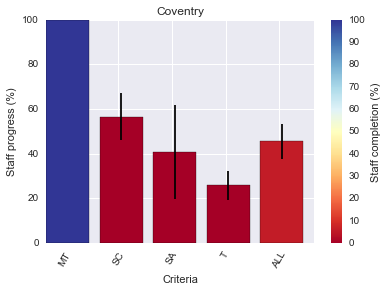

In [1144]:
def PLOT_bar_chart(df_A,df_A_std,df_B,i):
    '''
    Plot the 4 criteria and combined scores for a dealership with a colour gradient
    
    '''   
    plt.figure()

    x = df_A.columns
    dy = map(lambda x:100.*x,df_A_std.iloc[i])
    y = map(lambda x:100.*x,df_A.iloc[i])
    z = map(lambda x:100.*x,df_B.iloc[i])
    
    title = dealership_names[df_A.index[i]]
    
    plot = plt.scatter(z, z, c = z,vmin=0,vmax=100., cmap = 'RdYlBu')
    plt.clf()
    cb = plt.colorbar(plot)
    cb.set_label('Staff completion (%)')
    
    plt.bar(np.arange(len(y)),y,yerr=dy,color = cm.RdYlBu([i / 100. for i in z]),ecolor='k')

    plt.title('{}'.format(title))
    plt.ylabel('Staff progress (%)')
    plt.xlabel('Criteria')
    
    plt.xticks()
    plt.xticks(np.arange(len(y))+0.35,x,rotation=60)

    plt.show()
    
    return 

PLOT_bar_chart(df_progress,df_progress_std,df_completion,3)

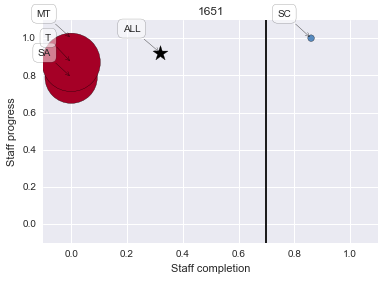

In [971]:
def PLOT_scatter_chart(df_A,df_Astd,df_B,i):
    '''
    Plot the 4 criteria and combined scores for a dealership with a colour gradient
    
    '''   
    plt.figure()

    x = df_A.columns
    y = df_A.iloc[i]
    s = df_Astd.iloc[i]
    z = df_B.iloc[i]
    #print y
    #print z
    
    title = df_A.index[i]

    plt.scatter(z[:-1], y[:-1], c = z[:-1], cmap = 'RdYlBu',vmin=0,vmax=1,s=[((i+0.1)*35)**3. for i in s])
    plt.scatter(z[-1:], y[-1:], marker='*',s=250,color='k')
    
    labels = ['{}'.format(i) for i in x]
    for label, posx, posy in zip(labels, z, y):
        plt.annotate(
            label,
            xy=(posx, posy), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
    plt.title('{}'.format(title))
    plt.ylabel('Staff progress')
    plt.xlabel('Staff completion')
    plt.axvline(x=0.7,color='k')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])

    plt.show()
    
    return 

PLOT_scatter_chart(df_progress,df_progress_std,df_completion,5)

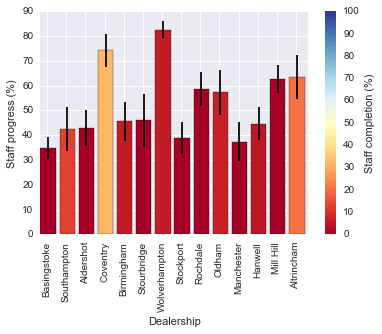

In [1146]:
#Dealer overview plot

def dealer_overview(df_A,df_A_std,df_B):
    '''
    produce a plot displaying the 'ALL' column for all dealers on a single plot.
    '''
    progress_dict = {}
    progress_err_dict = {}
    completion_dict = {}
    
    x = []
    
    for i in dealers:
        progress_dict[dealership_names[i]] = df_A.ix[i][4]
        progress_err_dict[dealership_names[i]] = df_A_std.ix[i][4]
        completion_dict[dealership_names[i]] = df_B.ix[i][4]
        x.append(dealership_names[i])
        
    plt.figure()
    
    y = [i*100. for i in progress_dict.values()]
    dy = [i*100. for i in progress_err_dict.values()]
    z = [i*100. for i in completion_dict.values()]
    
    #title = df_A.index[i]
    
    plot = plt.scatter(z, z, c = z,vmin=0,vmax=100, cmap = 'RdYlBu')
    plt.clf()
    cb = plt.colorbar(plot)
    cb.set_label('Staff completion (%)')
    
    plt.bar(np.arange(len(y)),y,yerr=dy,color = cm.RdYlBu([i / 100. for i in z]),ecolor='k')
    
    #plt.title('{}'.format(title))
    plt.ylabel('Staff progress (%)')
    plt.xlabel('Dealership')
    
    plt.xticks()
    plt.xticks(np.arange(len(y))+0.35,x,rotation=90)
    
    plt.show()   
    
    return

dealer_overview(df_progress,df_progress_std,df_completion)

In [ ]:
df_progress

In [1046]:
dealers

[1525,
 1533,
 1535,
 1633,
 1650,
 1651,
 1655,
 1692,
 1693,
 1694,
 1708,
 1877,
 1878,
 1883]